# Problem 1 - Direction-of-Arrival (DOA) Estimation

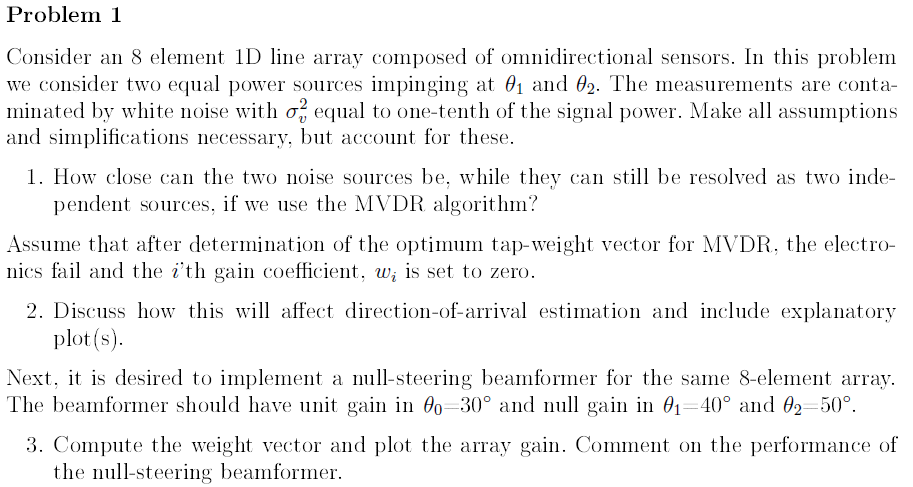

## 1)

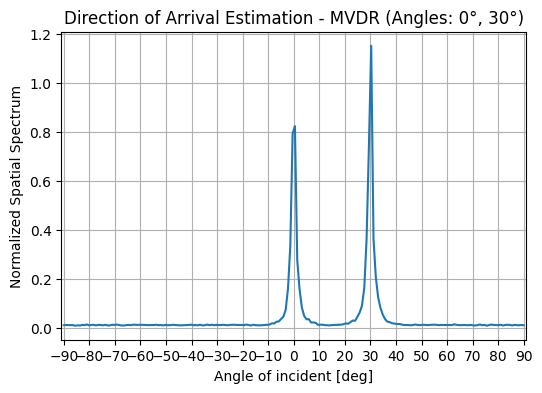

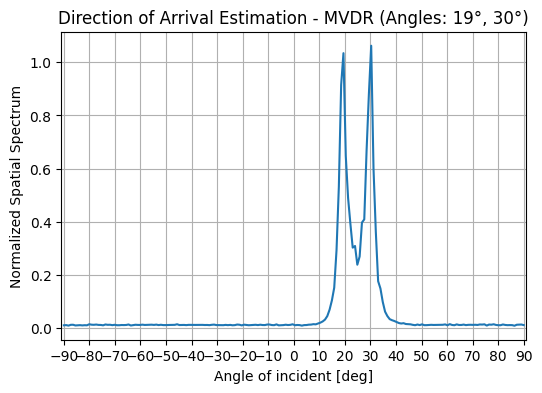

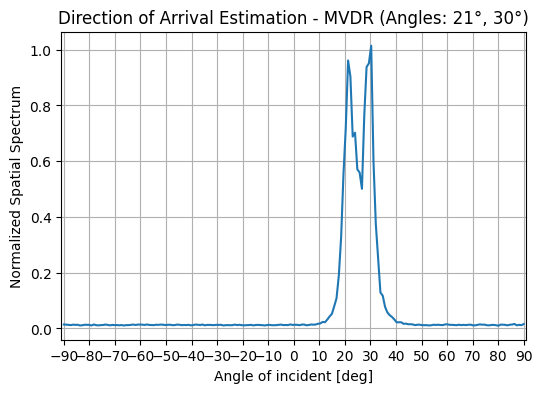

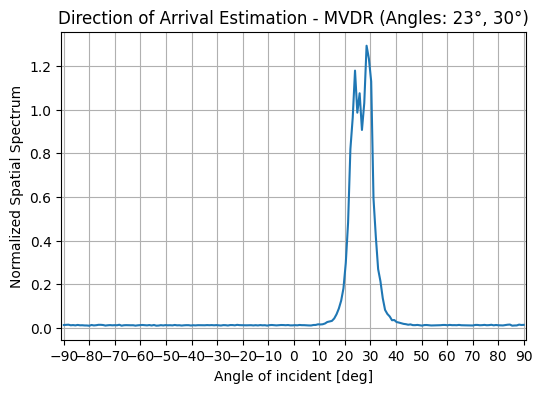

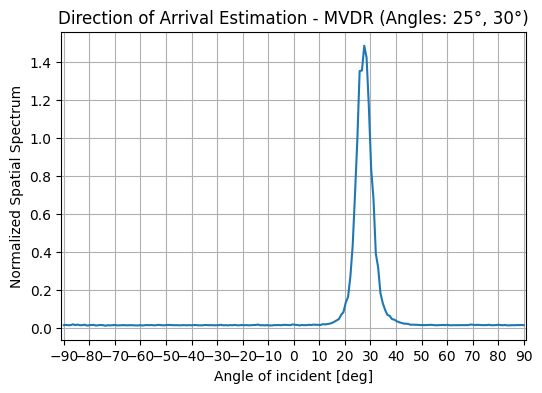

SNR = 10.0


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os

def MVDR_DOA(N, M, P, sig2, angle_pairs, observation_angles, savefig=False, w_fail=False):
    """
    MVDR beamformer for DOA estimation and spectrum plotting for multiple angle pairs.

    Parameters:
    - N: int
        Number of time samples.
    - M: int
        Number of array elements.
    - P: list of float
        Power of the two incoming signals [P1, P2].
    - sig2: float
        Variance of the additive noise.
    - angle_pairs: list of tuple
        List of pairs of incident angles for the two incoming signals [(theta1, theta2), ...].
    - observation_angles: ndarray
        Array of observation angles (degrees).

    Returns:
    - results: dict
        Dictionary containing the spatial spectrum for each angle pair.
    """
    rand_index = np.random.randint(0,M)
    printed = False
    def MVDR(N, M, theta_obs, theta1, theta2, P1, P2, sig2):
        nonlocal printed
        # Steering vectors for the two incident signals
        s1 = np.array([np.exp(1j * np.pi * np.sin(np.deg2rad(theta1)) * i) for i in range(M)])
        s2 = np.array([np.exp(1j * np.pi * np.sin(np.deg2rad(theta2)) * i) for i in range(M)])
        
        # Random signal content
        rand1 = np.random.normal(0, np.sqrt(P1), N)
        rand2 = np.random.normal(0, np.sqrt(P2), N)
        
        # Construct received signal vectors
        X = np.zeros((M, N), dtype=np.complex128)
        for n in range(N):
            noise = np.random.normal(0, np.sqrt(sig2), M)
            X[:, n] = rand1[n] * s1 + rand2[n] * s2 + noise  # Combined received signal
        
        # Compute covariance matrix (Rhat)
        Rhat = np.matmul(X, np.conj(X.T)) / N
        
        # Steering vector at observation angle
        s = np.array([np.exp(1j * np.pi * np.sin(np.deg2rad(theta_obs)) * i) for i in range(M)])
        
        # Optimal weight vector
        w_opt = np.linalg.pinv(Rhat) @ s / (np.conj(s).T @ np.linalg.pinv(Rhat) @ s)
        if (w_fail == True):
            w_opt[rand_index] = 0
            if not printed:
                print(f"Failure at {rand_index}'th gain coefficent")
                printed = True

        # Spatial spectrum
        S_theta = np.dot(np.conj(w_opt),np.matmul(Rhat,w_opt))
        return w_opt, S_theta
    
    for pair in angle_pairs:
        theta1, theta2 = pair
        w_theta = np.zeros((len(observation_angles),M),dtype=np.complex128)
        S_theta = np.zeros((len(observation_angles)),dtype=np.complex128)
        G_theta = np.zeros((len(observation_angles)),dtype=np.complex128)

        for i,a in enumerate(observation_angles):
            w, S = MVDR(N, M, a, theta1, theta2, P[0], P[1], sig2)
            g_val = 0
            for x in range(M):
                g_val += w[x]*np.exp(x*1j*np.pi*np.sin(a))
            G_theta[i] = g_val
            w_theta[i] = w
            S_theta[i] = S

        # Plot the results for this pair of angles
        plt.figure(figsize=(6, 4))
        plt.plot(observation_angles, S_theta, label=f"Angles: {theta1}°, {theta2}°")
        plt.title(f"Direction of Arrival Estimation - MVDR (Angles: {theta1}°, {theta2}°)")
        plt.xlabel("Angle of incident [deg]")
        plt.ylabel("Normalized Spatial Spectrum")
        plt.xlim([-91, 91])
        plt.xticks(np.arange(-90, 91, 10))
        plt.grid()

        if (savefig == True):
            # Save the plot with proper naming
            file_name = f"MVDR_DOA_{theta1}_{theta2}.png"
            plt.savefig(os.path.join("Plots", file_name), dpi=300)
        plt.show()
        plt.close()  # Close the plot to avoid overlapping figures
    return S_theta, G_theta, w_theta

# Example Usage
N = 200  # Number of time samples
M = 8  # Number of array elements
P = [1, 1]  # Power of the two incoming signals
sig2 = P[0] / 10  # Variance of additive noise
angle_pairs = [(0, 30), (19, 30),(21, 30),(23, 30), (25, 30)]  # List of angle pairs for the two signals
observation_angles = np.linspace(-90, 90, 200)  # Observation angles (degrees)

# Call the function for multiple angle pairs
S_theta, G_theta, G_theta = MVDR_DOA(N, M, P, sig2, angle_pairs, observation_angles, savefig = False)

SNR = 10*np.log10(P[0]/sig2)
print(f"SNR = {SNR}")

## 2)

Failure at 5'th gain coefficent


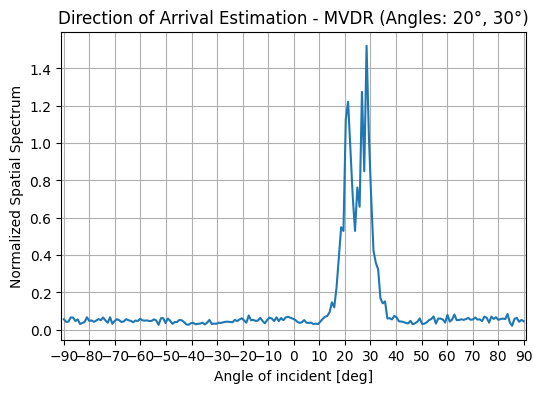

SNR = 10.0


In [81]:
N = 200  # Number of time samples
M = 8  # Number of array elements
P = [1, 1]  # Power of the two incoming signals
sig2 = P[0] / 10  # Variance of additive noise
angle_pairs = [(20, 30)]  # List of angle pairs for the two signals
observation_angles = np.linspace(-90, 90, 200)  # Observation angles (degrees)

# Call the function for multiple angle pairs
S_theta, G_theta, G_theta = MVDR_DOA(N, M, P, sig2, angle_pairs, observation_angles, savefig=False, w_fail=True)

SNR = 10*np.log10(P[0]/sig2)
print(f"SNR = {SNR}")

## 3)

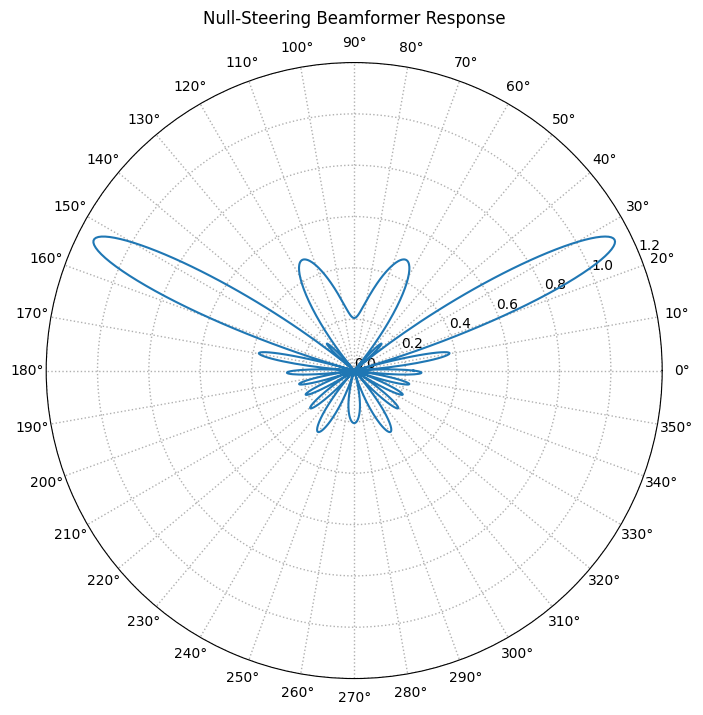

In [132]:
import numpy as np
import matplotlib.pyplot as plt

def null_steering_beamformer(theta_desired, theta_nulls, M):
    """
    Compute the null-steering beamformer weights.
    
    Parameters:
    - theta_desired: float
        Desired direction of the signal (degrees).
    - theta_nulls: list of float
        List of null directions (degrees).
    - M: int
        Number of array elements.
    
    Returns:
    - w_ns: ndarray
        Null-steering beamformer weight vector.
    """
    # Convert angles to radians
    theta_desired_rad = np.deg2rad(theta_desired)
    theta_nulls_rad = np.deg2rad(theta_nulls)
    
    # Construct the steering matrix S
    S = np.zeros((M, len(theta_nulls) + 1), dtype=np.complex128)
    S[:, 0] = np.array([np.exp(1j * np.pi * np.sin(theta_desired_rad) * i) for i in range(M)])
    for j, theta in enumerate(theta_nulls_rad):
        S[:, j + 1] = np.array([np.exp(1j * np.pi * np.sin(theta) * i) for i in range(M)])
    
    # Construct the constraint vector e0
    e0 = np.zeros(len(theta_nulls) + 1, dtype=np.complex128)
    e0[0] = 1  # Gain constraint for the desired direction
    
    # Compute the null-steering weight vector using Eq. (18.42)
    w_ns = S @ np.linalg.pinv(S.conj().T @ S) @ e0
    return w_ns

def plot_null_steering_polar(theta_desired, theta_nulls, M, observation_angles):
    """
    Plot the null-steering beamformer response as a polar plot.
    
    Parameters:
    - theta_desired: float
        Desired direction of the signal (degrees).
    - theta_nulls: list of float
        List of null directions (degrees).
    - M: int
        Number of array elements.
    - observation_angles: ndarray
        Array of observation angles (degrees).
    """
    # Compute the beamformer weights
    w_ns = null_steering_beamformer(theta_desired, theta_nulls, M)
    
    # Compute the array response
    response = []
    for theta in observation_angles:
        steering_vector = np.array([np.exp(1j * np.pi * np.sin(np.deg2rad(theta)) * i) for i in range(M)])
        response.append(np.abs(np.dot(w_ns.conj().T, steering_vector)))
    
    # Normalize the response
    response = np.array(response)

    # Convert angles to radians for polar plotting
    observation_angles_rad = np.deg2rad(observation_angles)
    
    # Plot the polar beam pattern
    plt.figure(figsize=(8, 8))
    ax = plt.subplot(111, polar=True)
    ax.plot(observation_angles_rad, response)
    ax.set_title("Null-Steering Beamformer Response", va='bottom')
    ax.set_rticks(np.arange(0, 1.4, 0.2))  # Set radial ticks at 0.2 intervals
    # ax.set_rlabel_position(-22.5)  # Move the radial labels slightly
    ax.grid(True, linestyle=':', linewidth=1)
    # Customize angle ticks
    angle_ticks = np.arange(0,360,10) # Custom angles in degrees
    ax.set_thetagrids(angle_ticks)
    plt.show()

# Example Usage
theta_desired = 30  # Desired direction (degrees)
theta_nulls = [40, 50]  # Null directions (degrees)
M = 10  # Number of array elements
observation_angles = np.linspace(0, 360, 1000)  # Observation angles (degrees)

# Plot the null-steering response as a polar plot
plot_null_steering_polar(theta_desired, theta_nulls, M, observation_angles)


# Problem 2 - Matched Filter and Signal-to-Noise Ratio (SNR)

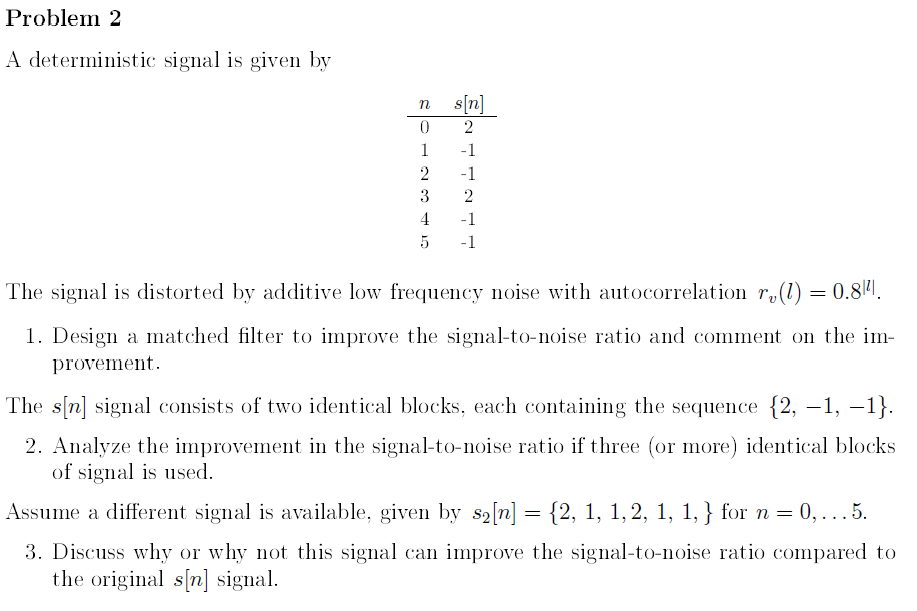

## 1)

## 2)

## 3)

# Problem 3 - Autocorrelation and Spectral Analysis

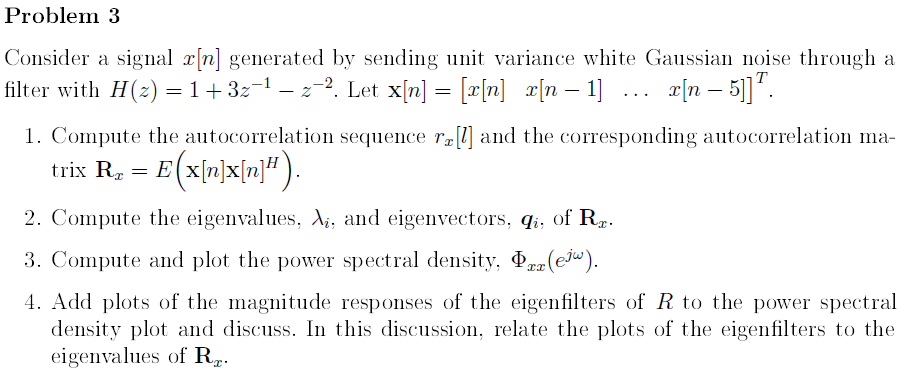

## 1)

## 2)

## 3)

## 4)